<h1 style="text-align:center;font-size:30px;" >Image Forgery Detection</h1>

<h1> 1. Problem Statement</h1>

<h2> 1.1 Description </h2>

Digital images are everywhere. However, how we deal with digital image processing can raise several legal and ethical questions that we must address. Before action can be taken on the basis of a questionable image (an image whose content truthfulness is under objection), we must detect something about the image itself.

In the last years, the field of Digital Image Forensics has emerged with several tools and algorithms presented to help researchers and forensics experts to interpret the authenticity of digital documents. However, the lack of a clear benchmark and common comparison protocol of such algorithms has limited us to gauge them under real-world conditions.

In this context, the IEEE Information Forensics and Security Technical Committee (IFS-TC) launched a detection and localization forensics challenge, the First Image Forensics Challenge.

<h3>Terminology</h3>

- Fake image : An image that has been manipulated/doctored using the two most common manipulation operations namely: copy/pasting and image splicing.
- Pristine image : An image that has not been manipulated except for the resizing needed to bring all images to a standard size as per competition rules.
- Image splicing : The splicing operations can combine images of people, adding doors to buildings, adding trees and cars to parking lots etc. The spliced images can also contain resulting parts from copy/pasting operations. The image receiving a spliced part is called a "host" image. The parts being spliced together with the host image are referred to as "aliens".
<br>

The competition was divided in 2 phases :
- Phase 1 : It required participating teams to identify fake images from pristine ones.
- Phase 2 : It required participants to reconstruct the mask used to create a fake image.

This case study will be focussing only on phase 1

Credits : IEEE IFS-TC<br>
http://ifc.recod.ic.unicamp.br/fc.website/index.py?sec=1<br>

<h2> 1.2 Sources/Useful Links</h2>

- Source : http://ifc.recod.ic.unicamp.br/fc.website/index.py?sec=5

__ Useful Links __
- research paper - https://ieeexplore.ieee.org/abstract/document/4806202
- research paper - https://ieeexplore.ieee.org/abstract/document/7823911

<h1>2. Machine Learning Probelm </h1>

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import imresize
from imageio import imread
import shutil
import pandas as pd
import pickle
from tqdm import tqdm_notebook, tqdm
from sklearn.model_selection import train_test_split
import seaborn as sns
from pylab import rcParams
# rcParams['figure.figsize']=10,10
import sys
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
import cv2
%matplotlib inline

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

Data is made available as a tar file which when unzipped gives a folder dataset-dist.<br> 
dataset-dist/phase-01/training has 2 folders
- fake : containing all fake images along with associated masks
- pristine : containing all pristine images

In [9]:
print('Number of fake images = {}'.format((len(os.listdir('dataset-dist/phase-01/training/fake'))-1)/2))

Number of fake images = 450.0


In [13]:
print('Number of pristine images = {}'.format((len(os.listdir('dataset-dist/phase-01/training/pristine/')))))

Number of pristine images = 1050


<h3> 2.1.2 Example fake image </h3>

In [76]:
arr=imageio.imread('dataset-dist/phase-01/training/fake/'+'092b43f88eab0ae3ecc0eb0ccbe37c82.png')

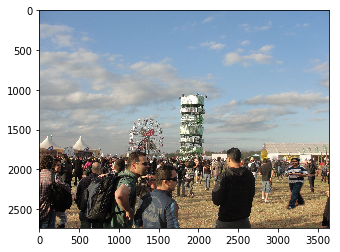

In [77]:
plt.imshow(arr)

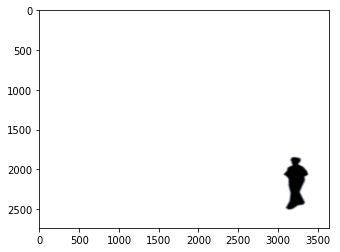

In [78]:
# Mask applied
arr=imageio.imread('dataset-dist/phase-01/training/fake/'+'092b43f88eab0ae3ecc0eb0ccbe37c82.mask.png')
plt.imshow(arr)

<h2> 2.2 Mapping to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given image need to predict if it is fake or not. </p>

<h3> 2.2.2 Performance Metrics </h3>

The metric of interest in first phase is the percentage of good classification, normalized by each class. That is, first is calculated the score of the pristine class

 score_pristine = (# correct pristine classifications / # pristine images for test)

and the score of the fake class

score_fake = (# correct fake classifications / # fake images for test)

Then, the final score is defined as the arithmetic mean of these two scores.

score_final = (score_pristine + score_fake) / 2

In addition to competition metric we will also be using log loss, since in the real world we would also be interested in knowing the probability of an image being fake

Metrics:
- average of TPR and TNR
- Binary confusion matrix
- Log loss

<h1>3. Exploratory Data Analysis </h1>

<h2> 3.1. Number of images </h2>

In [79]:
print('Number of fake images = {}'.format((len(os.listdir('dataset-dist/phase-01/training/fake/'))-1)/2)) # the folder contains both fake image and its mask
print('Number of pristine images = {}'.format((len(os.listdir('dataset-dist/phase-01/training/pristine/')))))

Number of fake images = 450.0
Number of pristine images = 1050


<h2> 3.2. Image shape </h2>

In [147]:
fake_path = 'dataset-dist/phase-01/training/fake/'
pristine_path = 'dataset-dist/phase-01/training/pristine_clean/'

In [13]:
fakes = os.listdir(fake_path)[1:]
pristines = os.listdir(pristine_path)

In [105]:
fakes[:10] # mask followed by image

['010543abfbd0db1e9aa1b24604336e0c.mask.png',
 '010543abfbd0db1e9aa1b24604336e0c.png',
 '022354380a1a17ff49226c9eae21a11f.mask.png',
 '022354380a1a17ff49226c9eae21a11f.png',
 '0294345b3b2324b195cb3b30e91d7678.mask.png',
 '0294345b3b2324b195cb3b30e91d7678.png',
 '0363353570f16ff0a73aa0a03a7795b8.mask.png',
 '0363353570f16ff0a73aa0a03a7795b8.png',
 '0830004e471e511458600f0763ce19f3.mask.png',
 '0830004e471e511458600f0763ce19f3.png']

In [90]:
pristines[:10]

['0001d52e2fd94f30c2bca0449763a752.png',
 '000bc3906100ede4b1374cea075adedb.png',
 '002e23c036a05de656242f5ce6ab2e15.png',
 '003f2d6e572e2587ffa809f78ff4a5c4.png',
 '00d56bffe2d757a4e4625cc2d0bd0de9.png',
 '00dd93f9e4af553929e54e66c2a3186e.png',
 '00dffa8cb9db22527454bfa3c03b484b.png',
 '00e079b66d9e9f99892bbb81d9d6cd57.png',
 '00e3659be9c1fec47c739f79252840e3.png',
 '00ec0ffe0cd029ad4551680484a007d7.png']

In [107]:
# segregate masks from images
if not os.path.isdir(fake_path+'masks/'):
    os.mkdir(fake_path+'masks/')
    for fake in fakes:
        if len(fake.split('.'))==3:
            shutil.move(fake_path+fake, fake_path+'masks/')
else:
    print('Segregated already')

Segregated already


<h2> 3.2. Image shape fake images</h2>

In [11]:
fakes = os.listdir(fake_path)[1:-1]

In [113]:
fake_shapes=[]
for fake in fakes:
    fake_shapes.append(imageio.imread(fake_path+fake).shape)

In [115]:
for i in range(20):
    ind=np.random.randint(0, len(fake_shapes))
    print(str(ind) +'\t'+ str(fake_shapes[ind]) +'\t'+fakes[ind])

201	(600, 800, 4)	b47c970b9a25c103951ab48c55727ecc.png
148	(771, 1024, 3)	ae62c81c35af25f591fee642ade58245.png
153	(768, 1024, 3)	aeb96ad12870526f4b964184e4b77103.png
304	(768, 1024, 3)	c7bebc1bd86c69b8117482029f8506f2.png
278	(768, 1024, 3)	c2ced35e09624934e6ac8ea922d6f216.png
338	(768, 1024, 3)	cd37a14624e4d3b04584b054ec761314.png
180	(765, 1024, 3)	b1bc3b7d2942eda3e73788c489e95d13.png
177	(768, 1024, 3)	b192b6242d69e023a4c2f26b42feadab.png
270	(768, 1024, 3)	c15b8f5dfe00c18107ba52ce25fc33e0.png
233	(768, 1024, 3)	bac7fb0f429c30179ca36411f11713ed.png
196	(768, 1024, 3)	b3f8eaa84b5f310be720b0e856b4eb51.png
415	(3000, 4000, 3)	da87f75ad935467d3c8d0ab08a559e76.png
108	(768, 1024, 3)	a570fb86a76eefb5d38a74d029415770.png
326	(1067, 1600, 3)	cb73316904b4dfa07e2f0066fdc91242.png
246	(765, 1024, 3)	bc6699010f8031e38623087db86466b1.png
171	(768, 1024, 3)	b12b7e18c131d3414662d00022cc5d0f.png
373	(792, 1188, 3)	d402dcd0cbd09bcc950a22003b8251b4.png
382	(768, 1024, 4)	d531b1cefbdd804a28399c46965a

Some fake images have 4 channels

In [116]:
for fake in fakes:
    if imageio.imread(fake_path+fake).shape[2]>4:
        print('5 channels in image ' + fake)

In [117]:
for fake in fakes:
    if imageio.imread(fake_path+fake).shape[2]<3:
        print('Less than 3 channels in image ' + fake)

In [177]:
for fake in fakes:
    if len(imageio.imread(fake_path+fake).shape)<=2:
        print(fake)

All images have 4 or 3 channels

In [160]:
four_channel_fakes=[]
for fake in fakes:
    if imageio.imread(fake_path+fake).shape[2]==4:
        four_channel_fakes.append(fake)
        
three_channel_fakes = [f for f in fakes if f not in four_channel_fakes]

In [161]:
len(four_channel_fakes)

64

In [162]:
len(three_channel_fakes)

386

In [14]:
heights=[]
widths=[]

for fake in fakes:
    img=imread(fake_path+fake)
    heights.append(img.shape[0])
    widths.append(img.shape[1])

In [15]:
print('minimum height = {}'.format(min(heights)))
print('maximum height = {}'.format(max(heights)))

print('minimum width = {}'.format(min(widths)))
print('maximum width = {}'.format(max(widths)))

minimum height = 480
maximum height = 4288
minimum width = 640
maximum width = 4320


<h2> 3.3. Image shape masks</h2>

In [6]:
mask_path = fake_path + 'masks/'

In [12]:
masks = os.listdir(mask_path)

In [119]:
mask_shapes=[]
for mask in masks:
    mask_shapes.append(imread(mask_path+mask).shape)

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:953: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


In [121]:
for i in range(20):
    ind=np.random.randint(0, len(mask_shapes))
    print(str(ind) +'\t'+ str(mask_shapes[ind]) +'\t'+masks[ind])

121	(598, 848, 3)	aa3b4f7caf9de8c1d6551c33045fb4c1.mask.png
160	(1536, 2048, 4)	afe1529ef8aaec50a917345e7280f9c2.mask.png
97	(2304, 3072)	a24271ffaff5625d6d77bd1b8db7f06f.mask.png
334	(1042, 1389)	cccbca215f38e9a03c46f73265bba889.mask.png
353	(768, 1024)	d0122ee951d52ee1198b9c402c0a75bf.mask.png
142	(1536, 2048, 4)	ad71b41fd8257bfb9bf303008a92f68e.mask.png
264	(771, 1024)	bf3bbec50ea288905e42bbfaf2c682bc.mask.png
414	(768, 1024)	da69d49cc6fd90ae7a2d494009ef46cf.mask.png
172	(771, 1024)	b12fb5198adce69091a77caac294016c.mask.png
181	(768, 1024)	b1fb2e2690c484ef7b0a75698150ed27.mask.png
423	(806, 1075)	df2f15d3d496f356e95aaf027d17dcaa.mask.png
215	(768, 1024)	b81629220178f4be3d145ba0986852ce.mask.png
449	(2144, 2848, 3)	fedd664fb16748292deb66f75e1da4bc.mask.png
246	(765, 1024)	bc6699010f8031e38623087db86466b1.mask.png
68	(1536, 2048, 4)	8569531f0cfe6fed6f0911100c8c8d56.mask.png
277	(771, 1024)	c2ccae30ccc8189fe03319b604cdde8b.mask.png
291	(1200, 1600)	c658e082c4a76075a2f91c731b1f79a0.mask

In [123]:
for mask in masks:
    img=imageio.imread(mask_path+mask)
    if len(img.shape)>2 and img.shape[2]>4:
        print('More than 4 channels in image ' + mask)

In [124]:
for mask in masks:
    img=imageio.imread(mask_path+mask)
    if len(img.shape)>2 and img.shape[2]<3:
        print('Less than 3 channels in image ' + mask)

In [129]:
one_channel_masks=[]
for mask in masks:
    if len(imageio.imread(mask_path+mask).shape)==2:
        one_channel_masks.append(mask)

In [163]:
three_channel_masks=[]
for mask in masks:
    img=imageio.imread(mask_path+mask)
    if len(img.shape)==3 and img.shape[2]==3:
        three_channel_masks.append(mask)

four_channel_masks=[m for m in masks if ((m not in one_channel_masks) and (m not in three_channel_masks))]

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:953: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


In [164]:
len(three_channel_masks)

65

In [165]:
len(four_channel_masks)

55

In [132]:
print(str(len(one_channel_masks))+' masks have only one channel i.e. grayscale')

330 masks have only one channel i.e. grayscale


All masks have 1, 3 or 4 channels

In [16]:
heights=[]
widths=[]

for mask in masks:
    img=imread(mask_path+mask)
    heights.append(img.shape[0])
    widths.append(img.shape[1])

print('minimum height = {}'.format(min(heights)))
print('maximum height = {}'.format(max(heights)))

print('minimum width = {}'.format(min(widths)))
print('maximum width = {}'.format(max(widths)))

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:953: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


minimum height = 480
maximum height = 4288
minimum width = 640
maximum width = 4320


In [21]:
i=0
for mask, fake in tqdm_notebook(zip(masks, fakes)):
    mask_img=imread(mask_path+mask)
    fake_img=imread(fake_path+fake)
    if mask_img.shape[:2]!=fake_img.shape[:2]:
        i+=1
        print(str(mask_img.shape)+' '+str(fake_img.shape))

(598, 848, 3) (768, 1024, 3)
(598, 848, 3) (768, 1024, 3)
(2304, 3072, 4) (1536, 2048, 3)
(598, 848, 3) (768, 1024, 3)
(598, 848, 3) (768, 1024, 3)
(598, 848, 3) (768, 1024, 3)


C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:953: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


(598, 848, 3) (768, 1024, 3)
(598, 848, 3) (768, 1024, 3)


<h2> 3.3. Image shape pristines</h2>

In [100]:
pristine_shapes=[]
for pristine in pristines:
    pristine_shapes.append(imageio.imread(pristine_path+pristine).shape)

In [159]:
for i in range(20):
    ind=np.random.randint(0, len(pristine_shapes))
    print(str(ind) +'\t'+ str(pristine_shapes[ind]) +'\t'+pristines[ind])

335	(575, 1024, 3)	1f65722961c1f54001401933670c078e.png
92	(768, 1024, 3)	0b53aa61ae3f6c6bc4b0cbb9d3e1b494.png
14	(768, 1024, 3)	01c86605fa24b57755ef6797443213d9.png
108	(768, 1024, 3)	0bf7b1f315d2e537e101e8ea09707cdd.png
652	(768, 1024, 3)	4b2afad66eb966a4d353b1c00bbfd0a0.png
354	(768, 1024, 3)	2a4846ae50d3aad698997d16459aabed.png
498	(768, 1024, 3)	3ad07b4f9fba7043ad7f1d7b8d1ba322.png
682	(768, 1024, 3)	4cd5e9a9b028f804302bb435f3ba0548.png
646	(768, 1024, 4)	4b0328c1c0c0a20cabd216e72f0e1002.png
1044	(683, 1024, 3)	7adb9d32243310909277163361e1a834.png
587	(768, 1024, 3)	3e1ce0b5d43bd87897198dc75b0fc39a.png
599	(768, 1024, 3)	3eb4dac35b0af9e0d60e609e8ed4ed0b.png
490	(768, 1024, 3)	3a7f78afa41fc79c60edffe1e1853f06.png
1041	(768, 1020, 3)	7ac72b3a5779aa5ee6c44a9816c2a844.png
797	(768, 1020, 3)	5cb31a4e9c401164c04a60b23437987c.png
584	(768, 1024, 3)	3deb3cb2c8f1d3179dcb8ba43f9df7db.png
572	(768, 1024, 3)	3d4cadd27ab1dddb34b8c1f2e22a8269.png
53	(680, 1024, 3)	06c190007f980b9d58a25a6db43332

In [167]:
three_channel_pristines=[]

for pristine in pristines:
    img=imageio.imread(pristine_path+pristine)
    if len(img.shape)==3 and img.shape[2]==3:
        three_channel_pristines.append(pristine)

In [169]:
one_channel_pristines=[]

for pristine in pristines:
    img=imageio.imread(pristine_path+pristine)
    if len(img.shape)<3:
        one_channel_pristines.append(pristine)
    
four_channel_pristines=[p for p in pristines if (p not in one_channel_pristines) and (p not in three_channel_pristines)]

In [170]:
len(one_channel_pristines)

3

In [175]:
for pristine in one_channel_pristines:
    img=imageio.imread(pristine_path+pristine)
    print(img.shape)

(768, 1024)
(768, 1024)
(768, 1024)


In [171]:
len(three_channel_pristines)

1025

In [172]:
len(four_channel_pristines)

22

In [183]:
table={}
table['pristines']=[3, 1025, 22, 1050]
table['fakes']=[0, 386, 64, 450]
table['masks']=[330, 65, 55, 450]
pd.DataFrame(table, index=['1 channel', '3 channel', '4 channel', 'total'])

,pristines,fakes,masks
1 channel,3,0,330
3 channel,1025,386,65
4 channel,22,64,55
total,1050,450,450


In [46]:
four_channel_image = imread(pristine_path+four_channel_pristines[21])

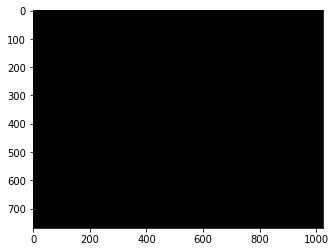

In [47]:
plt.imshow(four_channel_image)

Only use 3 channel pristines, discard 1 and 4 channel images

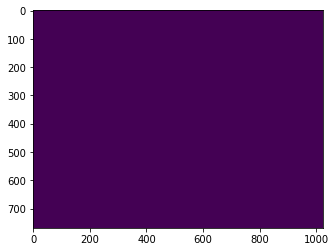

In [55]:
four_channel_image = imread(fake_path+four_channel_fakes[49])
plt.imshow(four_channel_image[:,:,3])

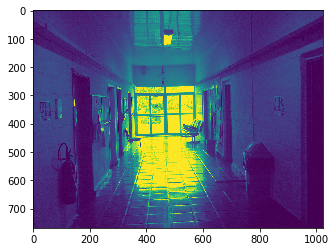

In [58]:
plt.imshow(four_channel_image[:,:,2])

Discard channel 4 of fake images with 4 channels

In [59]:
four_channel_image = imread(mask_path+four_channel_masks[54])

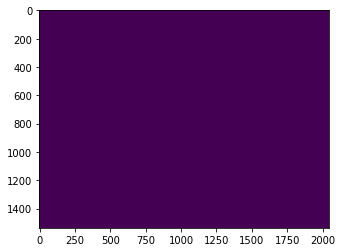

In [60]:
plt.imshow(four_channel_image[:,:,3])

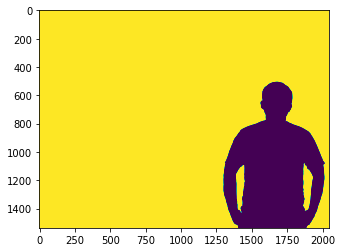

In [62]:
plt.imshow(four_channel_image[:,:,2])

Discard channel 4 of 4 channel masks. In fact the feature engineering phase requires only one channel information. The same information is duplicated across other 2 channels

In [17]:
heights=[]
widths=[]

for pristine in pristines:
    img=imread(pristine_path+pristine)
    heights.append(img.shape[0])
    widths.append(img.shape[1])

print('minimum height = {}'.format(min(heights)))
print('maximum height = {}'.format(max(heights)))

print('minimum width = {}'.format(min(widths)))
print('maximum width = {}'.format(max(widths)))

minimum height = 575
maximum height = 768
minimum width = 576
maximum width = 1024


<h4>Checkpoint 1</h4>

In [236]:
with open('one_channel_pristines.pickle', 'wb') as f:
    pickle.dump(one_channel_pristines, f)
    
with open('three_channel_pristines.pickle', 'wb') as f:
    pickle.dump(three_channel_pristines, f)

with open('four_channel_pristines.pickle', 'wb') as f:
    pickle.dump(four_channel_pristines, f)
    
with open('three_channel_fakes.pickle', 'wb') as f:
    pickle.dump(three_channel_fakes, f)
    
with open('four_channel_fakes.pickle', 'wb') as f:
    pickle.dump(four_channel_fakes, f)

with open('one_channel_masks.pickle', 'wb') as f:
    pickle.dump(one_channel_masks, f)
    
with open('three_channel_masks.pickle', 'wb') as f:
    pickle.dump(three_channel_masks, f)
    
with open('four_channel_masks.pickle', 'wb') as f:
    pickle.dump(four_channel_masks, f)

In [2]:
with open('one_channel_pristines.pickle', 'rb') as f:
    one_channel_pristines = pickle.load(f)
    
with open('three_channel_pristines.pickle', 'rb') as f:
    three_channel_pristines = pickle.load(f)

with open('four_channel_pristines.pickle', 'rb') as f:
    four_channel_pristines=pickle.load(f)
    
with open('three_channel_fakes.pickle', 'rb') as f:
    three_channel_fakes=pickle.load(f)
    
with open('four_channel_fakes.pickle', 'rb') as f:
    four_channel_fakes=pickle.load(f)

with open('one_channel_masks.pickle', 'rb') as f:
    one_channel_masks=pickle.load(f)
    
with open('three_channel_masks.pickle', 'rb') as f:
    three_channel_masks=pickle.load(f)
    
with open('four_channel_masks.pickle', 'rb') as f:
    four_channel_masks=pickle.load(f)

After all data cleaning we have :
- 1025 pristine images (3 channels)
- 450 fake images (3 channels)
- 450 masks (1 channel)

masks will be used to sample image patches for creation of train and cv data (label = fake) to be fed into CNN. This ensures that CNN learns boundaries created due to forgery operations because of change in statistics of underlying image at these boundaries

<h2> 4. Dataset preparation </h2>

<h3> 4.1. Concatenate pristine and fake images </h3>

In [111]:
pristines_final=[]
for pristine in pristines:
    img=imread(pristine_path+pristine)
    if len(img.shape)<3:
        continue
    if img.shape[2]==4:
        continue
    pristines_final.append(pristine)

In [119]:
len(pristines_final)

1025

In [112]:
fake_images=[]
fakes_final=[]
for fake in fakes:
    img=imread(fake_path+fake)
    try:
        fake_images.append(img[:,:,:3])
        fakes_final.append(fake)
    except IndexError:
        print(f'image {fake} has only 1 channel')

In [114]:
len(fake_images)

450

In [115]:
image_names=[]
for i in range(0, len(pristine_images)):
    image_names.append(pristines_final[i])
for i in range(0, len(fake_images)):
    image_names.append(fakes_final[i])

In [120]:
len(image_names)

1475

<h3> 4.2. Train test split </h3>

We have 1025 pristine images and 450 fake images. Since no timestamp has been given we resort to random splitting.<br>
80% train, 20% test

In [121]:
labels=[0]*1025+[1]*450

In [122]:
x_train, x_test, y_train, y_test = train_test_split(image_names, labels, test_size=0.2, stratify=labels)

<h3> 4.3. Feature engineering on train set </h3>

As suggested in https://ieeexplore.ieee.org/abstract/document/7823911 we will extract image patches from training images both from pristine and fake images. First we will use masks to sample fake images at boundaries. These will be labeled as fake images. Then same number of patches will be sampled from pristine images to ensure a balanced dataset

In [124]:
x_train_images=[]
for x in x_train:
    try:
        img=imread(pristine_path+x)
    except FileNotFoundError:
        img=imread(fake_path+x)
    
    x_train_images.append(img)

In [130]:
heights=[]
widths=[]

for image in x_train_images:
    heights.append(image.shape[0])
    widths.append(image.shape[1])

In [131]:
max(heights)

4288

In [132]:
min(heights)

480

In [133]:
max(widths)

4320

In [134]:
min(widths)

640

In [136]:
x_train_mask_names=[]
for ind, x in enumerate(x_train):
    if y_train[ind]==1:
        x_train_mask_names.append(x.split('.')[0]+'.mask.png')

In [164]:
x_train_fakes_names=[]
x_train_fake_images=[]
for ind, x in enumerate(x_train):
    if y_train[ind]==1:
        x_train_fakes_names.append(x)
        x_train_fake_images.append(x_train_images[ind])

In [242]:
x_train_pristines_names=[]
x_train_pristine_images=[]
for ind, x in enumerate(x_train):
    if y_train[ind]==0:
        x_train_pristines_names.append(x)
        x_train_pristine_images.append(x_train_images[ind])

In [145]:
x_train_masks=[]
for m in x_train_mask_names:
    
    img=imread(mask_path+m)
    
    if len(img.shape)>2:
        img=img[:,:,0]
        
    x_train_masks.append(img)

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:953: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


In [3]:
x_train_masks=[]
for i in range(9):
    with open('data/x_train_masks_'+str(i)+'.pickle', 'rb') as f:
        x_train_masks.extend(pickle.load(f))

In [7]:
with open('data/x_train_fakes_names.pickle', 'rb') as f:
    x_train_fakes_names=pickle.load(f)
    
x_train_fake_images=[]
for img in x_train_fakes_names:
    x_train_fake_images.append(imread(fake_path+img))

In [149]:
x_train_pristine_images=[]

with open('data/x_train.pickle', 'rb') as f:
    x_train_pristine_image_names=pickle.load(f)

for name in x_train_pristine_image_names:
    if os.path.isfile(pristine_path+name):
        x_train_pristine_images.append(imread(pristine_path+name))

In [167]:
x_train_fake_images[0].shape

(768, 1024, 3)

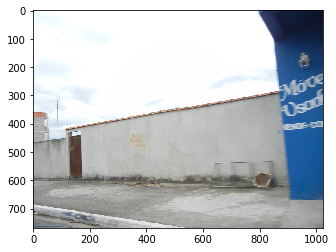

In [21]:
plt.imshow(x_train_fake_images[0][:,:,:3])

In [146]:
heights=[]
widths=[]

for image in x_train_masks:
    heights.append(image.shape[0])
    widths.append(image.shape[1])

In [147]:
max(heights)

4288

In [148]:
min(heights)

480

In [149]:
max(widths)

4320

In [150]:
min(widths)

640

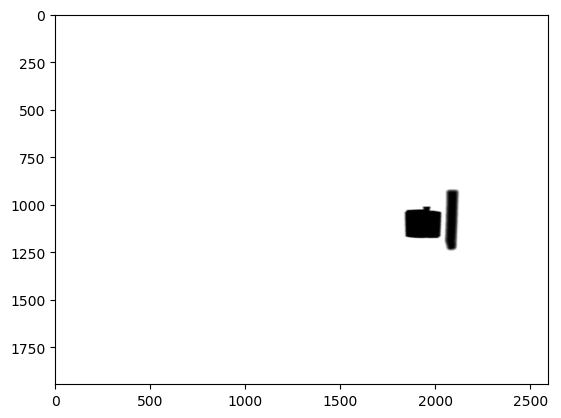

In [55]:
plt.imshow(x_train_masks[28], cmap='gray')

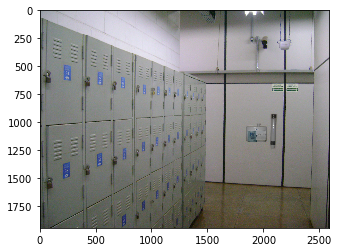

In [24]:
plt.imshow(x_train_fake_images[28])

In [29]:
# Convert grayscale images to binary
binaries=[]

for grayscale in x_train_masks:
    blur = cv2.GaussianBlur(grayscale,(5,5),0)
    ret,th = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    binaries.append(th)

In [56]:
~binaries[28]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

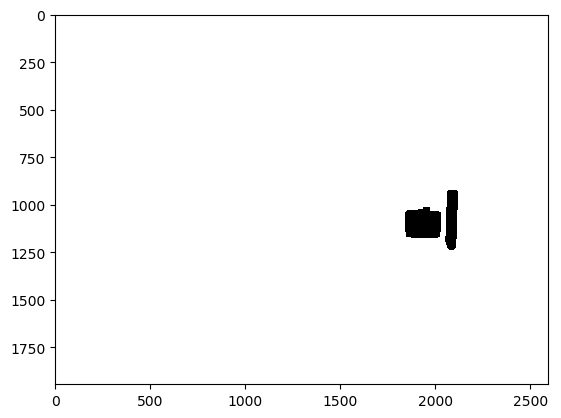

In [57]:
plt.imshow(binaries[28], cmap='gray')

In [39]:
mask_pixels = [np.count_nonzero(~binaries[i]) for i in range(len(binaries))]

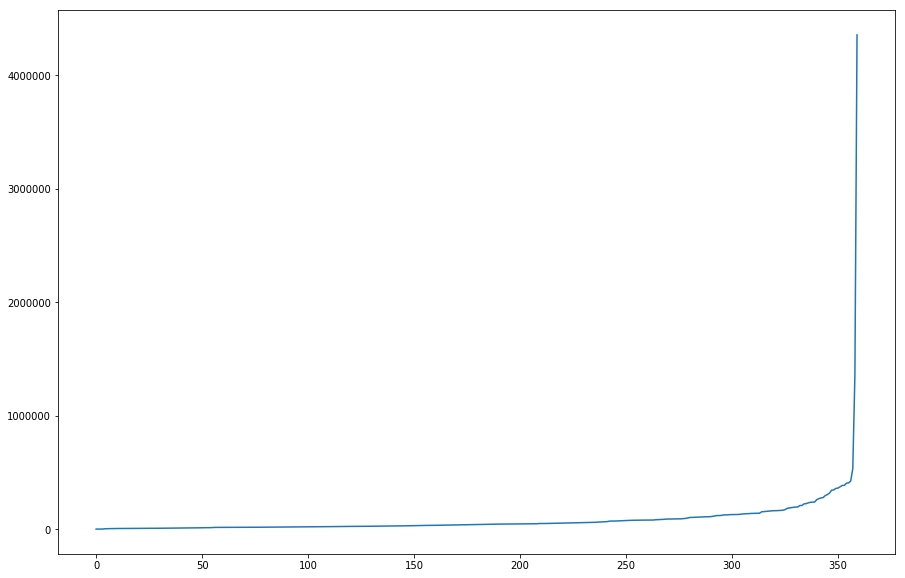

In [40]:
rcParams['figure.figsize']=15,10
plt.plot(sorted(mask_pixels))

In [42]:
0.25*64*64

1024.0

In [44]:
0.4*64*64

1638.4

In [45]:
np.percentile(sorted(mask_pixels), np.arange(.1,1,.1))

array([1302.463, 1322.926, 1346.007, 1378.676, 1411.345, 1431.386,
       1434.617, 1437.848, 1979.078])

We must capture information from every image. We use patch size of 64 * 64 and ensuring minimum 40% contribution from forged area and authentic area.<br>This ensures that more than 99% of masks are covered including discriminative boundary at the same time

In [259]:
def count_255(mask):
    i=0
    for row in range(mask.shape[0]):
        for col in range(mask.shape[1]):
            if mask[row,col]==255:
                i+=1
    return i

In [291]:
def sample_fake(img, mask):
    kernel_size=64
    stride=32
    
    samples=[]
    
    for y_start in range(0, img.shape[0]-kernel_size+1, stride):
        for x_start in range(0, img.shape[1]-kernel_size+1, stride):
            
            c_255=count_255(mask[y_start:y_start+kernel_size, x_start:x_start+kernel_size])
            
            if (c_255>1600) and (kernel_size*kernel_size-c_255>1600):
                samples.append(img[y_start:y_start+kernel_size, x_start:x_start+kernel_size, :3])    
        
    return samples

In [282]:
sample=sample_fake(x_train_fake_images[5], x_train_masks[5])

(3240, 4320, 3)


In [294]:
len(sample)

6

In [295]:
x_train_fake_images[5].shape

(3240, 4320, 3)

In [296]:
x_train_masks[5].shape

(3240, 4320)

In [51]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

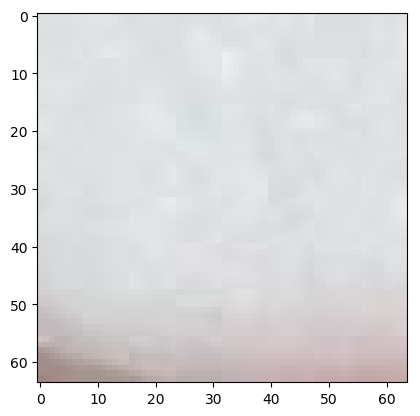

In [300]:
plt.imshow(sample[2])

In [301]:
len(x_train_fake_images)

360

In [234]:
samples_fake=[]
i=0
for fake, mask in zip(x_train_fake_images, x_train_masks):
    image_samples=sample_fake(fake, mask)
    for sample in image_samples:
        samples_fake.append(sample)
        i+=1

Above code is trivially parallelizable, check sample_fake.py and sample_fake_binaries.py

Using kernel size of 64 and stride of 32 produces about 4000 fake samples. Decreasing the stride generates a larger dataset of fake images. We try both stride=32 on grayscale images and stride=8 on binary images.

In [58]:
samples_fake_grayscale = np.load('k64 grayscale 40percent stride32/sample_fakes_np.npy')
samples_fake_binary = np.load('k64 binary 25percent stride8/sample_fakes_np.npy')

In [60]:
fake_samples_grayscale = samples_fake_grayscale.shape[0]
fake_samples_binary = samples_fake_binary.shape[0]

In [61]:
print(f'we have {fake_samples_grayscale} fake samples each of shape 64 * 64 using grayscale masks')
print(f'we have {fake_samples_binary} fake samples each of shape 64 * 64 using binary masks')

we have 4802 fake samples each of shape 64 * 64 using grayscale masks
we have 175609 fake samples each of shape 64 * 64 using binary masks


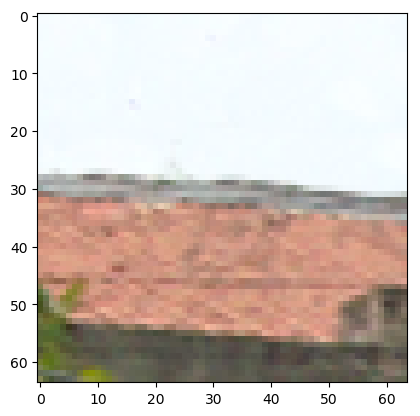

In [63]:
plt.imshow(samples_fake_grayscale[501])

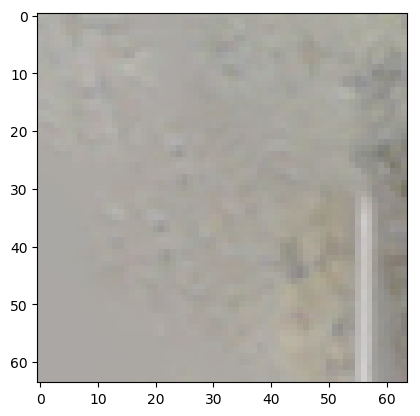

In [139]:
plt.imshow(samples_fake_binary[120000])

Now to create negative samples we randomly sample 64 * 64 patches from authentic images

In [227]:
def sample_random(img, num_samples, stride=8):
    kernel_size=64
    
    x_start=0
    y_start=0
    samples=[]
    
    for y_start in range(0, img.shape[0] - kernel_size + 1, stride):
        for x_start in range(0, img.shape[1] - kernel_size + 1, stride):

            #c_255 = count_255(mask[y_start:y_start + kernel_size, x_start:x_start + kernel_size])

            #if (c_255 > threshold) and (kernel_size * kernel_size - c_255 > threshold):
            samples.append(img[y_start:y_start + kernel_size, x_start:x_start + kernel_size, :3])

    
    indices=np.random.randint(0, len(samples), min(len(samples), num_samples))
    
    sampled=[]
    for i in indices:
        sampled.append(samples[i])
    
    return sampled

In [152]:
# some images have all pixels=0 those images have been manually deleted

In [218]:
len(x_train_pristine_images)

807

In [220]:
len(x_train_fake_images)

360

In [222]:
4802/807

5.950433705080545

In [223]:
6*807

4842

6 samples per pristine image

In [233]:
samples_pristine_grayscale=np.ndarray(shape=(4842, 64, 64, 3), dtype=np.dtype('uint8'))

i=0
for pristine_img in x_train_pristine_images:
    
    samples=sample_random(pristine_img, 6, stride=32)
    for sample in samples:
        samples_pristine_grayscale[i, :, :, :]=sample
        i+=1
print(i)

4842


In [229]:
len(x_train_pristine_images)

807

In [173]:
175609/807

217.6071871127633

In [174]:
217*807

175119

217 samples per pristine image

In [234]:
samples_pristine_binary=np.ndarray(shape=(175119, 64, 64, 3), dtype=np.dtype('uint8'))

i=0
for pristine_img in x_train_pristine_images:
    
    samples=sample_random(pristine_img, 217)
    for j, sample in enumerate(samples):
        samples_pristine_binary[i, :, :, :]=sample
        i+=1
print(i)

175119


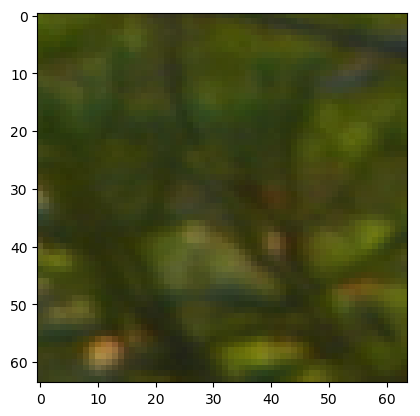

In [235]:
plt.imshow(samples_pristine_grayscale[4823])

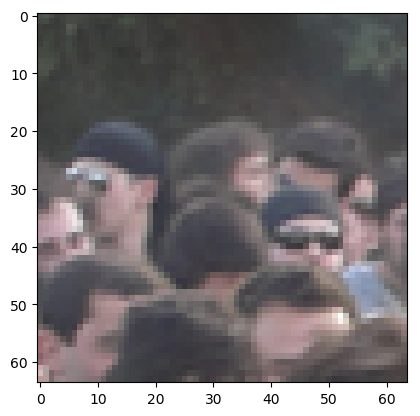

In [236]:
plt.imshow(samples_pristine_binary[4823])

In [240]:
print(f'number of fake samples in\n1. binary mask extraction using stride of 8 = {len(samples_fake_binary)}\n\
2. in grayscale mask extraction using stride of 32 = {len(samples_fake_grayscale)}\n\n\
number of pristine samples in\n1. binary mask extraction using stride of 8 = {len(samples_pristine_binary)}\n\
2. in grayscale mask extraction using stride of 32 = {len(samples_pristine_grayscale)}')

number of fake samples in
1. binary mask extraction using stride of 8 = 175609
2. in grayscale mask extraction using stride of 32 = 4802

number of pristine samples in
1. binary mask extraction using stride of 8 = 175119
2. in grayscale mask extraction using stride of 32 = 4842


In [242]:
train_labels_binary=[0]*len(samples_pristine_binary)+[1]*len(samples_fake_binary)
train_labels_grayscale=[0]*len(samples_pristine_grayscale)+[1]*len(samples_fake_grayscale)

<h4>Checkpoint 2</h4>

x_train, x_test, y_train, y_test, samples_fake, samples_pristine, train_labels, x_train_fake_images, x_train_fakes_names, x_train_images, x_train_mask_names, x_train_masks, x_train_pristine_images, x_train_pristines_names

In [241]:
np.save('k64 grayscale 40percent stride32/samples_pristine.npy', samples_pristine_grayscale)
np.save('k64 binary 25percent stride8/samples_pristine.npy', samples_pristine_binary)

In [473]:
with open('data/x_train_fake_images.pickle', 'wb') as f:
    pickle.dump(x_train_fake_images, f)

with open('data/x_train_images.pickle', 'wb') as f:
    pickle.dump(x_train_images, f)
        
with open('data/x_train_pristine_images.pickle', 'wb') as f:
    pickle.dump(x_train_pristine_images, f)

MemoryError: 

In [485]:
for i in range(len(x_train_fake_images)):
    with open('data/x_train_fake_images_'+str(i)+'.pickle', 'wb') as f:
        pickle.dump(x_train_fake_images[i], f)

In [486]:
for i in range(len(x_train_images)):
    with open('data/x_train_images_'+str(i)+'.pickle', 'wb') as f:
        pickle.dump(x_train_images[i], f)

In [487]:
for i in range(len(x_train_pristine_images)):
    with open('data/x_train_pristine_images_'+str(i)+'.pickle', 'wb') as f:
        pickle.dump(x_train_pristine_images[i], f)

In [472]:
len(x_train_masks)

360

In [463]:
with open('data/x_train_masks.pickle', 'wb') as f:
    pickle.dump(x_train_masks[:50], f)

In [464]:
with open('data/x_train_masks_1.pickle', 'wb') as f:
    pickle.dump(x_train_masks[50:100], f)

In [465]:
with open('data/x_train_masks_2.pickle', 'wb') as f:
    pickle.dump(x_train_masks[100:150], f)

In [466]:
with open('data/x_train_masks_3.pickle', 'wb') as f:
    pickle.dump(x_train_masks[150:200], f)

In [467]:
with open('data/x_train_masks_4.pickle', 'wb') as f:
    pickle.dump(x_train_masks[200:250], f)

In [468]:
with open('data/x_train_masks_5.pickle', 'wb') as f:
    pickle.dump(x_train_masks[250:300], f)

In [469]:
with open('data/x_train_masks_6.pickle', 'wb') as f:
    pickle.dump(x_train_masks[300:350], f)

In [470]:
with open('data/x_train_masks_7.pickle', 'wb') as f:
    pickle.dump(x_train_masks[350:400], f)

In [243]:
# with open('x_train.pickle', 'wb') as f:
#     pickle.dump(x_train, f)

# with open('x_test.pickle', 'wb') as f:
#     pickle.dump(x_test, f)
    
# with open('y_train.pickle', 'wb') as f:
#     pickle.dump(y_train, f)

# with open('y_test.pickle', 'wb') as f:
#     pickle.dump(y_test, f)

# with open('samples_fake.pickle', 'wb') as f:
#     pickle.dump(samples_fake, f)

# with open('samples_pristine.pickle', 'wb') as f:
#     pickle.dump(samples_pristine, f)

with open('k64 binary 25percent stride8/train_labels.pickle', 'wb') as f:
    pickle.dump(train_labels_binary, f)
    
with open('k64 grayscale 40percent stride32/train_labels.pickle', 'wb') as f:
    pickle.dump(train_labels_grayscale, f)

with open('x_train_fakes_names.pickle', 'wb') as f:
    pickle.dump(x_train_fakes_names, f)

with open('x_train_mask_names.pickle', 'wb') as f:
    pickle.dump(x_train_mask_names, f)

with open('x_train_pristines_names.pickle', 'wb') as f:
    pickle.dump(x_train_pristines_names, f)

In [393]:
samples_pristine_grayscale = np.load('k64 grayscale 40percent stride32/samples_pristine_np.npy')
samples_fake_grayscale = np.load('k64 grayscale 40percent stride32/sample_fakes_np.npy')

with open('k64 grayscale 40percent stride32/train_labels.pickle', 'rb') as f:
    train_labels_grayscale = np.array(pickle.load(f))

In [ ]:
samples_pristine_binary = np.load('k64 binary 25percent stride8/samples_pristine_np.npy')
samples_fake_binary = np.load('k64 binary 25percent stride8/sample_fakes_np.npy')

with open('k64 binary 25percent stride8/train_labels.pickle', 'rb') as f:
    train_labels_binary = np.array(pickle.load(f))

In [244]:
samples_pristine_grayscale.shape

(4842, 64, 64, 3)

In [245]:
samples_fake_grayscale.shape

(4802, 64, 64, 3)

In [247]:
train_labels_grayscale.shape

(9644,)

In [248]:
samples_pristine_binary.shape

(175119, 64, 64, 3)

In [249]:
samples_fake_binary.shape

(175609, 64, 64, 3)

In [250]:
train_labels_binary.shape

(350728,)

In [251]:
# Concatenate authentic and fake image samples along axis=0 to generate train set for grayscale sampled images
train_data_grayscale = np.concatenate((samples_pristine_grayscale, samples_fake_grayscale), axis=0)

In [252]:
x_train, x_cv, y_train, y_cv = train_test_split(train_data_grayscale, train_labels_grayscale, test_size=0.3, stratify = train_labels_grayscale)

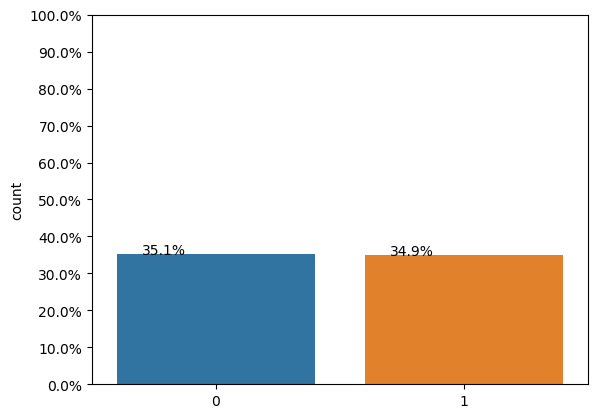

In [253]:
total = len(train_labels_grayscale)*1.
ax=sns.countplot(y_train)
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

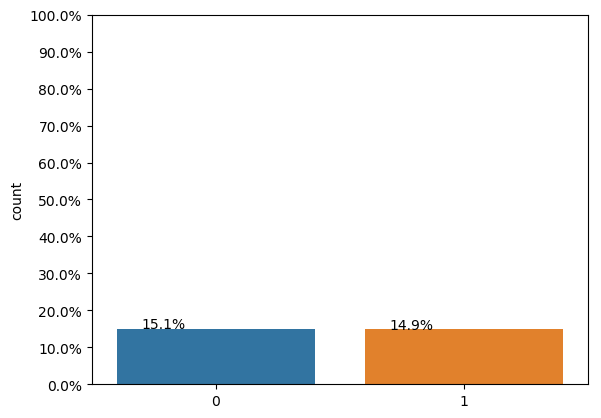

In [254]:
total = len(train_labels_grayscale)*1.
ax=sns.countplot(y_cv)
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

In [255]:
if not os.path.isdir('k64 grayscale 40percent stride32/train_data'):
    os.mkdir('k64 grayscale 40percent stride32/train_data')
    
    np.save('k64 grayscale 40percent stride32/train_data/x_train.npy', x_train)
    np.save('k64 grayscale 40percent stride32/train_data/x_cv.npy', x_cv)
    
    np.save('k64 grayscale 40percent stride32/train_data/y_train.npy', y_train)
    np.save('k64 grayscale 40percent stride32/train_data/y_cv.npy', y_cv)
else:
    print('train data exists')

In [256]:
# Concatenate authentic and fake image samples along axis=0 to generate train set for binary sampled images
train_data_binary = np.concatenate((samples_pristine_binary, samples_fake_binary), axis=0)

In [257]:
x_train, x_cv, y_train, y_cv = train_test_split(train_data_binary, train_labels_binary, test_size=0.3, stratify = train_labels_binary)

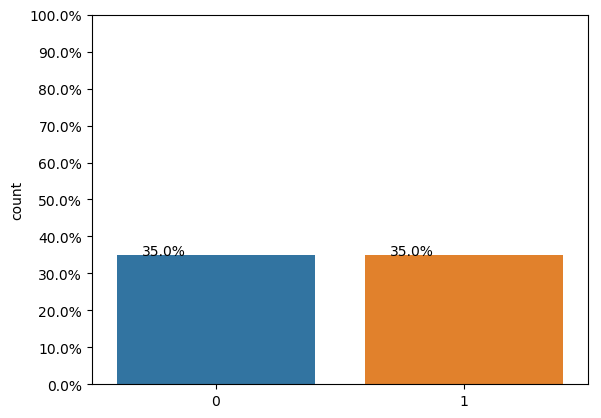

In [258]:
total = len(train_labels_binary)*1.
ax=sns.countplot(y_train)
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

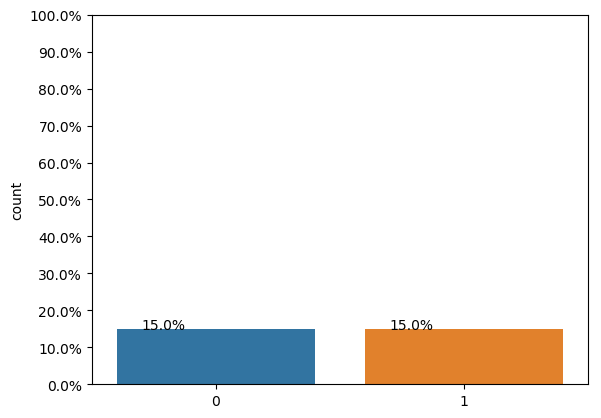

In [259]:
total = len(train_labels_binary)*1.
ax=sns.countplot(y_cv)
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

In [264]:
if not os.path.isdir('k64 binary 25percent stride8/train_data2'):
    os.mkdir('k64 binary 25percent stride8/train_data2')
    
    np.save('k64 binary 25percent stride8/train_data2/x_train.npy', x_train)
    np.save('k64 binary 25percent stride8/train_data2/x_cv.npy', x_cv)
    
    np.save('k64 binary 25percent stride8/train_data2/y_train.npy', y_train)
    np.save('k64 binary 25percent stride8/train_data2/y_cv.npy', y_cv)
else:
    print('train data exists')

<h2> 5. Deep learning models </h2>

In [2]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h3> 5.1. Random model (worst case performance)</h3>

Log loss on Test Data using Random Model 0.8800709892355876
Accuracy on Test Data using Random Model 0.5037555826228177


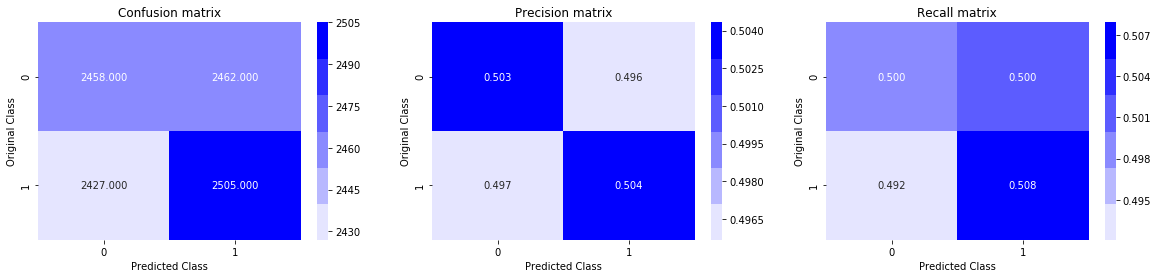

In [30]:
test_len=len(y_cv)
predicted_y_prob = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y_prob[i] = ((rand_probs/sum(sum(rand_probs)))[0])
    
print("Log loss on Test Data using Random Model",log_loss(y_cv, predicted_y_prob, eps=1e-15))
predicted_y =np.argmax(predicted_y_prob, axis=1)
print("Accuracy on Test Data using Random Model",accuracy_score(y_cv, predicted_y))

plot_confusion_matrix(y_cv, predicted_y)

Our CNN model must give log loss less than 0.89, accuracy more than 49.8%

<h3> 5.2. CNN architecture</h3>

In [3]:
import keras
from keras.models import load_model, Sequential
from keras.layers import Dense, Flatten

Using TensorFlow backend.


In [9]:
x_test=np.load('k64 binary 25percent stride8/x_test.npy')

y_test=np.load('k64 binary 25percent stride8/y_test.npy')

In [5]:
vgg_model=keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(64,64,3))

model_aug=Sequential()
model_aug.add(vgg_model)

top_model=Sequential()
top_model.add(Flatten(input_shape=(2, 2, 512)))
#model_aug.add(Dropout(0.3))
top_model.add(Dense(64, activation='relu'))

top_model.add(Dense(1, activation='sigmoid'))

model_aug.add(top_model)

for layer in model_aug.layers[0].layers[:17]:
    layer.trainable=False
        
model_aug.load_weights('k64 binary 25percent stride8/remote/hidden/fine_tuned_model_adam_weights.h5')

In [6]:
model_aug.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 131201    
Total params: 14,845,889
Trainable params: 2,491,009
Non-trainable params: 12,354,880
_________________________________________________________________


In [7]:
model_aug.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=1e-6), metrics=['accuracy'])

In [21]:
model_aug.evaluate(x_test, y_test, verbose=0)

[0.3122462222237693, 0.94645]